In [1]:
import lightning as L
import numpy as np
import torch
import torch.nn as nn
from torchdiffeq import odeint
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import copy
from lightning.pytorch.callbacks import Callback

In [8]:
n_samples = 65000
batch_size = 256
latent_dim = 10
max_epochs = 2
lr = 1e-3

train_dataset = PhysicsDataset(n_samples=n_samples)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

decoder = Decoder(latent_dim=latent_dim)
pnode_func = PNODEFunc(latent_dim=latent_dim)
pnode = PNODE(pnode_func, latent_dim=latent_dim)
cnf = CNFROM(decoder, pnode)
model = Model(cnf, train_dataset) 

L.Trainer(accelerator="gpu", devices=1, max_epochs=max_epochs).fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | CNFROM | 599 K  | train
-----------------------------------------
599 K     Trainable params
0         Non-trainable params
599 K     Total params
2.400     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Training: |                                               | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

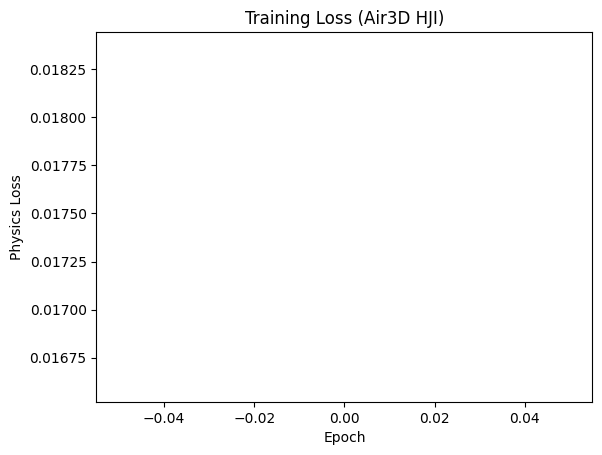

In [9]:
losses = np.array(model.loss_hist)
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Physics Loss")
plt.title("Training Loss (Air3D HJI)")
plt.show()

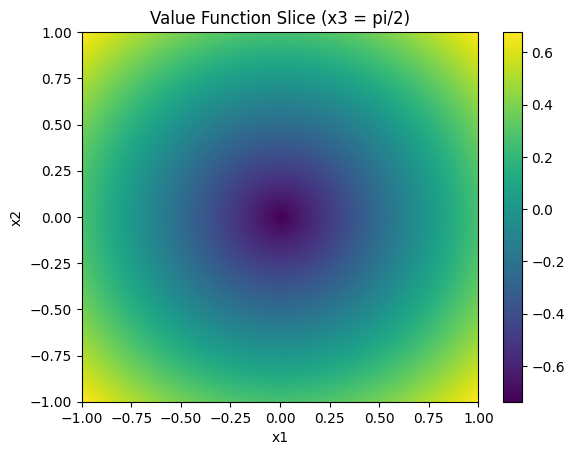

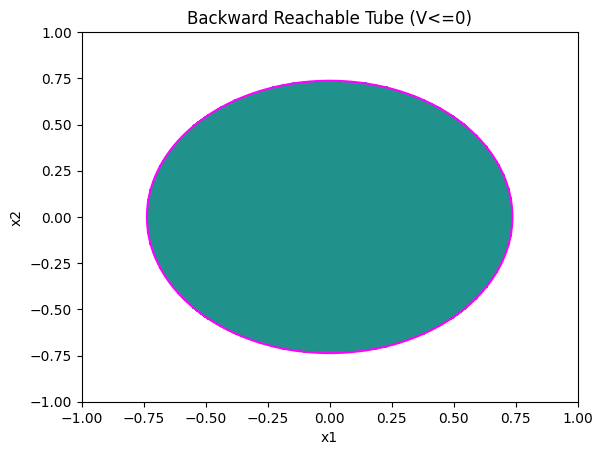

In [10]:
cnf_trained = model.model
cnf_trained.eval()
@torch.no_grad()
def eval_value_slice(cnf, tau=1.0, x3_val=np.pi/2, n=201):
    device = next(cnf.parameters()).device

    x1 = np.linspace(-1,1,n,dtype=np.float32)
    x2 = np.linspace(-1,1,n,dtype=np.float32)
    X1, X2 = np.meshgrid(x1, x2, indexing="xy")

    pts = np.stack([
        X1.reshape(-1),
        X2.reshape(-1),
        np.full(X1.size, x3_val, dtype=np.float32)
    ], axis=1)

    pts_t = torch.from_numpy(pts).to(device)
    tau_t = torch.full((pts_t.shape[0],), tau, device=device)

    V = cnf(pts_t, tau_t).cpu().numpy().reshape(n,n)
    return X1, X2, V
X1, X2, V = eval_value_slice(cnf_trained, tau=1.0)

plt.figure()
plt.imshow(
    V,
    origin="lower",
    extent=[-1,1,-1,1],
    aspect="auto"
)
plt.colorbar()
plt.title("Value Function Slice (x3 = pi/2)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

plt.figure()
plt.contourf(X1, X2, (V<=0).astype(float), levels=[0.5,1.5])
plt.contour(X1, X2, V, levels=[0], colors="magenta")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Backward Reachable Tube (V<=0)")
plt.show()